In [1]:
from typing import List, TypedDict
from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_ollama import OllamaEmbeddings, ChatOllama
from langchain_qdrant import Qdrant
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langgraph.graph import START, StateGraph, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain.schema import Document


In [2]:
#note: pypdf also records title, page numeber etc required by chain-5

from langchain_community.document_loaders import DirectoryLoader, PyMuPDFLoader

#loader = DirectoryLoader('/home/tom/Python/Tools/RAG and PDF/docs', glob="**/*.pdf", loader_cls=UnstructuredPDFLoader, show_progress=True)
loader = DirectoryLoader('docs', glob="**/*.pdf", loader_cls=PyMuPDFLoader, show_progress=True)
repo_files = loader.load()


100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.93it/s]


In [3]:

print(f"Number of files loaded: {len(repo_files)}")
#
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=150)
documents = text_splitter.split_documents(documents=repo_files)
print(f"Number of documents : {len(documents)}")

Number of files loaded: 13
Number of documents : 63


In [4]:
from langchain_ollama import OllamaEmbeddings
#from langchain_community.vectorstores import Qdrant
from langchain_qdrant import Qdrant

In [5]:
model_name = "nomic-embed-text"
embeddings = OllamaEmbeddings(model=model_name)

In [6]:
#Restore db

qdrant = Qdrant.from_existing_collection(
 embeddings,
 path="langchain_local_qdrant_pdf_orig",
 collection_name="my_documents",
)

In [7]:
retriever = qdrant.as_retriever()

In [8]:
import os
api_key = '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'
#os.environ["OPENAI_API_KEY"] = api_key

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
        temperature=0.7,
        model="qwen/qwen-vl-plus:free", 
        openai_api_key=api_key,
        openai_api_base="https://openrouter.ai/api/v1",
        #headers={"HTTP-Referer": constants.OPENROUTER_REFERRER},    
    )

In [10]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [11]:
local_model = "llama3.2"
llm = ChatOllama(model=local_model)

In [12]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = qdrant.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [13]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [14]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

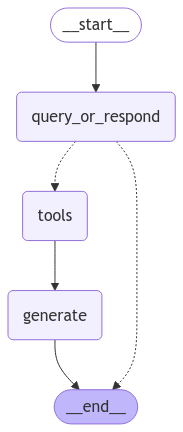

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [18]:
input_message = "summarize?"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

summarize?
================================== Ai Message ==================================
Tool Calls:
  summarize (08732f15-4a3e-49b1-b956-d5df43f8bc10)
 Call ID: 08732f15-4a3e-49b1-b956-d5df43f8bc10
  Args:
    x: MCTS is an algorithm used to build a search tree and find suitable adaptations for user interfaces.
    y: None
================================= Tool Message =================================
Name: summarize

Error: summarize is not a valid tool, try one of [retrieve].
================================== Ai Message ==================================

I don't know a "summarize" tool in this context. However, I can try to summarize our conversation: We discussed MCTS being used for building user interfaces by optimizing various parameters to improve their effectiveness. If you'd like more information on this topic, I can try to help further.
